# LDA Demonstration


In this notebook, we will build LDA models on various datasets. We'll use the gensim implementation of LDA, though sklearn also comes with one. 

We will also use the library spacy for preprocessing (specifically lemmatisation). Though you can also perform lemmatisation in NLTK, it is slightly more convenient and less verbose in spacy. For visualising the topics and the word-topic distributions (interactively!), we'll use the 'pyLDAvis' module.

In [1]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Amazon Product Reviews Dataset - Echo/Alexa

For building topic models, let's experiment with the Amazon product reviews dataset. We have a list of reviews of a few amazon products such as Kindle, Echo (Alexa) etc. 

In [2]:
df = pd.read_csv('7817_1.csv')

In [3]:
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


Let's now filter the dataframe to only one product - Amazon Echo. If you are not aware of Echo, <a href="https://www.amazon.in/Amazon-Echo-control-weather-Powered/dp/B0749YXL1J?tag=googinhydr18418-21">here's the amazon page</a>.

In [4]:
# filter for product id = amazon echo
df = df[df['asins']=="B01BH83OOM"]
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs
855,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,Look at this product as a portable speaker fir...,Great for what it does,NaN,NaN,Casey,NaN,8.416670e+11,1.75 lbs
856,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,This Amazon tap is not only a great Bluetooth ...,"Awesome, smart little portable speaker",NaN,NaN,Tazman3582,NaN,8.416670e+11,1.75 lbs


### Preprocessing

Let's first do some preprocessing. For tokenisation, though one can use NLTK as well, let's try using gensim's ```simple_preprocess``` this time. The preprocessing pipeline is mentioned below.<br>

1. Tokenize each review (using gensim)
2. Remove stop words (including punctuations)
3. Lemmatize (using spacy)

Though you can build topic models without lemmatisation, it is actually quite important (and highly recommended) because otherwise you may end up getting topics having similar words for e.g. *speaker, speakers* etc. (which are basically referring to the same thing - speaker).

Note that lemmatization uses POS tags of words, so we need to specify a list of POS tags - here we've used ```['NOUN', 'ADJ', 'VERB', 'ADV']``` .

In [5]:
# tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


The code below creates a list of stop words. The 'string' module in python comes with a list of punctuation characters, which we'll append to the builtin stopwords of NLTK.

In [6]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)


In [7]:
# functions for removing stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

**Important Note:** All models are not automatically downloaded with spacy, so you will need to do a ```python -m spacy download en``` to use its preprocessing methods.

In [8]:
# call functions

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# initialize spacy 'en' model, use only tagger since we don't need parsing or NER 
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'echo', 'replacement', 'second', 'big', 'reason', 'buy', 'standard', 'bluetooth', 'speaker', 'wifi', 'streaming', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'listen', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money']


In [9]:
# compare the nostop, lemmatised version with the original one
# note that speakers is lemmatised to speaker; 
print(' '.join(data_words[3]), '\n')
print(' '.join(data_lemmatized[3]))

look at this product as portable speaker first and an echo replacement second the big reason to buy this over standard bluetooth speakers is this has wifi streaming enabled when you are at home you can stream music with ease to it voice recognition is top notch and it really shines when using it with other smart home accessories the only problem is having to tap the microphone button for it to listen to your voice if you want bigger sound and always listening features spend the extra money on the amazon echo 

look product portable echo replacement second big reason buy standard bluetooth speaker wifi streaming enable home stream music ease voice recognition top notch really shine use smart home accessory problem tap listen voice want big sound always listen feature spend extra money


### Creating Dictionary and Corpus

Gensim's LDA requires the data in a certain format. Firstly, it needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.

In [10]:
# create dictionary and corpus
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(9, 1), (12, 2), (13, 3), (16, 1), (17, 2), (21, 4), (29, 1), (32, 1), (47, 1), (52, 1), (56, 5), (65, 1), (77, 1), (80, 3), (83, 1), (85, 2), (90, 1), (91, 1), (92, 2), (94, 2), (95, 1), (106, 2), (110, 1), (114, 1), (118, 1), (127, 2), (130, 1), (133, 1), (139, 1), (140, 1), (141, 2), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 2), (154, 1), (155, 2), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 2), (166, 1), (167, 3), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 2), (182, 1), (183, 2), (184, 1), (185, 5), (186, 1), (187, 3), (188, 2), (189, 1), (190, 3), (191, 1), (192, 1), (193, 1), (194, 1), (195, 6), (196, 1), (197, 1), (198, 1), (199, 2), (200, 1), (201, 2), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 2), (208, 1), (209, 2), (210, 1)]


The (3, 7) above represents the fact that the word with id=3 appears 7 times in the second document (review), word id 12 appears twice and so on. The nested list below shows the frequencies of words in the first document.

In [11]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('admit', 1),
  ('allow', 1),
  ('announce', 1),
  ('answer', 1),
  ('anyway', 1),
  ('app', 1),
  ('appealing', 1),
  ('associate', 1),
  ('avid', 1),
  ('battery', 3),
  ('buy', 1),
  ('choose', 2),
  ('command', 1),
  ('control', 1),
  ('convenience', 1),
  ('cook', 1),
  ('could', 2),
  ('day', 1),
  ('decide', 2),
  ('demand', 1),
  ('development', 1),
  ('device', 3),
  ('dot', 1),
  ('drain', 1),
  ('early', 2),
  ('easily', 2),
  ('echo', 5),
  ('echos', 1),
  ('enable', 1),
  ('especially', 1),
  ('fabulous', 1),
  ('financial', 1),
  ('first', 1),
  ('free', 6),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('hand', 6),
  ('high', 1),
  ('hope', 1),
  ('important', 1),
  ('introduce', 1),
  ('keep', 1),
  ('kitchen', 1),
  ('lack', 1),
  ('listener', 1),
  ('little', 2),
  ('lot', 1),
  ('love', 1),
  ('major', 1),
  ('make', 1),
  ('maximum', 1),
  ('microphone', 1),
  ('mind', 1),
  ('minimal', 1),
  ('mode', 2),
  ('music', 2),
  ('operation', 1),
  ('option', 2),
  ('orig

### Building the Topic Model

Let's now build the topic model. We'll define 10 topics to start with. The hyperparameter `alpha` affects sparsity of the document-topic
(theta) distributions, whose default value is 1. Similarly, the hyperparameter `eta` can also be specified, which affects the topic-word distribution's sparsity.



In [12]:
# help(gensim.models.ldamodel.LdaModel)

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Let's now print the topics found in the dataset.

In [14]:
# print the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"great" + 0.052*"sound" + 0.047*"use" + 0.035*"good" + 0.030*"love" + '
  '0.030*"speaker" + 0.028*"music" + 0.027*"work" + 0.027*"alexa" + '
  '0.024*"portable"'),
 (1,
  '0.101*"would" + 0.049*"recommend" + 0.049*"purchase" + 0.031*"think" + '
  '0.027*"may" + 0.026*"item" + 0.026*"much" + 0.026*"news" + 0.026*"want" + '
  '0.025*"still"'),
 (2,
  '0.051*"tap" + 0.049*"echo" + 0.027*"button" + 0.027*"voice" + 0.027*"add" + '
  '0.022*"activate" + 0.021*"push" + 0.019*"command" + 0.017*"anywhere" + '
  '0.017*"well"'),
 (3,
  '0.049*"size" + 0.040*"charge" + 0.032*"hold" + 0.031*"order" + '
  '0.030*"actually" + 0.027*"want" + 0.024*"stream" + 0.022*"phone" + '
  '0.016*"wireless" + 0.016*"case"'),
 (4,
  '0.066*"get" + 0.038*"tap" + 0.034*"play" + 0.029*"music" + 0.022*"little" + '
  '0.020*"thing" + 0.018*"say" + 0.014*"try" + 0.014*"find" + 0.013*"could"'),
 (5,
  '0.053*"need" + 0.049*"buy" + 0.046*"love" + 0.031*"gift" + 0.030*"wish" + '
  '0.030*"go" + 0.027*"press

Let's now evaluate the model using coherence score.

In [15]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43708922544068596


Now lets visualise the topics. The `pyLDAvis` library comes with excellent interactive visualisation capabilities.

In [16]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.350322  0.035382       1        1  45.279220
4      0.170658  0.081132       2        1  15.214373
2      0.090733 -0.221678       3        1  11.410355
1     -0.119492  0.171132       4        1   6.421712
5     -0.029387  0.150005       5        1   5.848590
3     -0.112545 -0.047988       6        1   4.878039
9     -0.044532 -0.064426       7        1   4.386046
6     -0.105511 -0.042208       8        1   3.011591
8     -0.106626 -0.020195       9        1   2.134572
7     -0.093621 -0.041155      10        1   1.415502, topic_info=            Term        Freq       Total Category  logprob  loglift
48          love  142.000000  142.000000  Default  30.0000  30.0000
391         easy   43.000000   43.000000  Default  29.0000  29.0000
34           get   84.000000   84.000000  Default  28.0000  28.0000
97         would   62.000000   62.000000  Default  27.0000  27.0000
91           use  185.000000  185.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1022    reliable    0.493586    1.213876  Topic10  -5.4689   3.3578
1023   unlocking    0.493586    1.213876  Topic10  -5.4689   3.3578
1027  competitor    0.492749    1.213292  Topic10  -5.4706   3.3566
1029  frequently    0.492749    1.213292  Topic10  -5.4706   3.3566
12       command    0.836807   24.777593  Topic10  -4.9410   0.8696

[430 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
277       1  0.995466        able
417       5  0.921197  absolutely
229       2  0.971524      access
1025      7  0.799917    accurate
141       3  0.976250    activate
...     ...       ...         ...
97        4  0.870732       would
97        5  0.128997       would
139       5  0.634178        year
139       7  0.253671        year
670       9  0.879729         yet

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 6, 4, 10, 7, 9, 8])

## Hyperparameter Tuning - Number of Topics and Alpha

Let's now tune the two main hyperparameters - number of topics and alpha. The strategy typically used is to tune these parameters such that the coherence score is maximised.

In [17]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [18]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

In [19]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.407720
1,0.01,6,0.418937
2,0.01,10,0.412063
3,0.01,15,0.382231
4,0.01,20,0.414264
5,0.10,2,0.429587
6,0.10,6,0.421284
7,0.10,10,0.398742
8,0.10,15,0.402339
9,0.10,20,0.405852


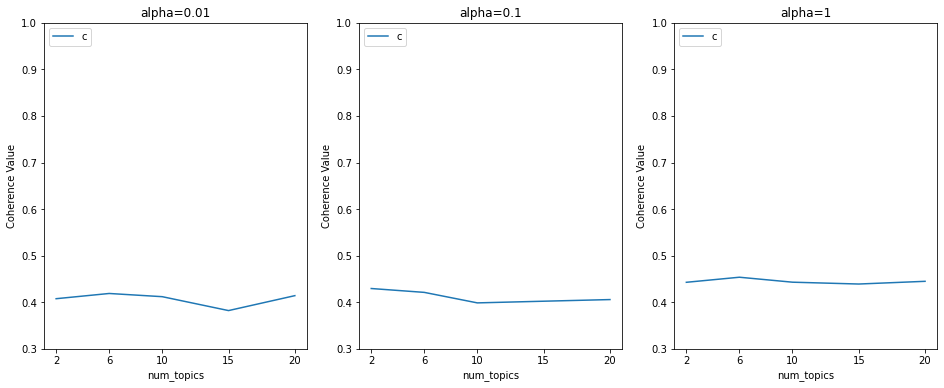

In [20]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df, alpha_range, num_topics_range)

In [21]:
# Build the LDA Model after hyper param tuning :

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,  #hypertuned
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.001, #hypertuned
                                           per_word_topics=True)


In [22]:
# print the 5 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.054*"great" + 0.049*"sound" + 0.032*"good" + 0.030*"use" + 0.027*"would" '
  '+ 0.024*"alexa" + 0.023*"enjoy" + 0.019*"speaker" + 0.018*"recommend" + '
  '0.017*"able"'),
 (1,
  '0.027*"easy" + 0.025*"sound" + 0.022*"use" + 0.019*"set" + 0.018*"music" + '
  '0.018*"great" + 0.017*"item" + 0.013*"news" + 0.012*"quality" + '
  '0.012*"press"'),
 (2,
  '0.034*"sound" + 0.031*"speaker" + 0.029*"echo" + 0.027*"tap" + 0.026*"good" '
  '+ 0.023*"portable" + 0.020*"well" + 0.020*"button" + 0.015*"great" + '
  '0.015*"connect"'),
 (3,
  '0.049*"love" + 0.047*"use" + 0.034*"music" + 0.024*"buy" + 0.020*"great" + '
  '0.019*"play" + 0.017*"phone" + 0.016*"alexa" + 0.014*"ask" + 0.013*"tap"'),
 (4,
  '0.039*"tap" + 0.034*"echo" + 0.018*"work" + 0.018*"music" + 0.017*"get" + '
  '0.015*"dot" + 0.015*"question" + 0.015*"hand" + 0.014*"great" + '
  '0.013*"time"')]


In [23]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4211501816471155


In [24]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.179723 -0.007687       1        1  24.170028
4      0.016714  0.106812       2        1  24.155770
3     -0.137989 -0.156115       3        1  21.507763
0      0.072853 -0.070844       4        1  15.608999
1     -0.131301  0.127834       5        1  14.557439, topic_info=         Term        Freq       Total Category  logprob  loglift
77      sound  172.000000  172.000000  Default  30.0000  30.0000
48       love  134.000000  134.000000  Default  29.0000  29.0000
91        use  166.000000  166.000000  Default  28.0000  28.0000
167      good  118.000000  118.000000  Default  27.0000  27.0000
26       echo  134.000000  134.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
292  purchase    8.346026   36.314669   Topic5  -4.9717   0.4566
255     phone    8.123139   38.092426   Topic5  -4.9987   0.3818
94       well    8.420636   67.378179   Topic5  -4.9628  -0.1526
353      need    7.404366   44.550402   Topic5  -5.0914   0.1325
93       want    7.248842   49.491448   Topic5  -5.1126   0.0061

[325 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
277       1  0.386243        able
277       4  0.606954        able
417       3  0.793330  absolutely
229       2  0.139383      access
229       3  0.836297      access
...     ...       ...         ...
97        2  0.162661       would
97        3  0.014787       would
97        4  0.517557       would
97        5  0.029575       would
670       5  0.948928         yet

[420 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

In [25]:
# The coherence score has not improved but there are clearer distinct topics identified here.
# If we have interpretability as our factor then this is better.

### Demonetisation Tweets

Let's now try identifying topics in tweets related to a specific topic - demonetisation. The overall pipeline is the same, apart from someextra preprocessing steps.

In [26]:
df = pd.read_csv("demonetization-tweets.csv", encoding = "ISO-8859-1")
print(df.shape)
df.head()

(14940, 16)


,Unnamed: 0,X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,8.014954e+17,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


In [27]:
# see randomly chosen sample tweets
df.text[random.randrange(len(df.text))]

'As prime minister asks Jan Jan Ki Baat on #Demonetization \r\nCitizens speak and write on @jankibaat1 \r\n#citizensvoice\r\n\r\nhttps://t.co/711DaPqjai'

In [28]:
df.text[:10]

0    RT @rssurjewala: Critical question: Was PayTM ...
1    RT @Hemant_80: Did you vote on #Demonetization...
2    RT @roshankar: Former FinSec, RBI Dy Governor,...
3    RT @ANI_news: Gurugram (Haryana): Post office ...
4    RT @satishacharya: Reddy Wedding! @mail_today ...
5    @DerekScissors1: Indias #demonetization: #Bla...
6    RT @gauravcsawant: Rs 40 lakh looted from a ba...
7    RT @Joydeep_911: Calling all Nationalists to j...
8    RT @sumitbhati2002: Many opposition leaders ar...
9    National reform now destroyed even the essence...
Name: text, dtype: object

Note that many tweets have strings such as RT, @xyz, etc. Some have URLs, punctuation marks, smileys etc. The following code cleans the data to handle many of these issues.

In [29]:
# remove URLs
def remove_URL(x):
            return x.replace(r'https[a-zA-Z0-9]*', "", regex = True)


# clean tweet text
def clean_tweets(tweet_col):
    
    df = pd.DataFrame({'tweet':tweet_col})
    
    df['tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['tweet'] = df['tweet'].replace("  ", " ")
    df['tweet'] = df['tweet'].replace(r'@[a-zA-Z0-9]*', '', regex=True)
    df['tweet'] = remove_URL(df['tweet'])
    df['tweet'] = df['tweet'].str.lower() 
    
    return(df)

cleaned_tweets = clean_tweets(df.text)
cleaned_tweets[:10]

,tweet
0,rt : critical question: was paytm informed abo...
1,rt _80: did you vote on #demonetization on mod...
2,rt : former finsec rbi dy governor cbdt chair ...
3,rt _news: gurugram haryana: post office employ...
4,rt : reddy wedding! _today cartoon #demonetiza...
5,: indias #demonetization: #blackmoney a sympt...
6,rt : rs 40 lakh looted from a bank in kishtwar...
7,rt _911: calling all nationalists to join\rwal...
8,rt : many opposition leaders are with on the ...
9,national reform now destroyed even the essence...


Since tweets often contain slang words such as *wat, rt, lol* etc, we can append the stopwords with a list of such custom words and remove them.

In [30]:
words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there",
                    "all","we","one","the","a","an","of","or","in","for","by","on","but","is","in",
                    "a","not","with","as","was","if","they","are","this","and","it","have","from","at",
                    "my","be","by","not","that","to","from","com","org","like","likes","so","said","from",
                    "what","told","over","more","other","have","last","with","this","that","such","when",
                    "been","says","will","also","where","why","would","today", "in", "on", "you", "r", "d", 
                    "u", "hw","wat", "oly", "s", "b", "ht", "rt", "p","the","th", "lol", ':']


# remove stop words, punctuations 
stop_words = set(list(stopwords.words('english') + 
                      list(string.punctuation) +
                      words_remove)) 

data_words = list(sent_to_words(cleaned_tweets.tweet.values.tolist(), deacc=False))


# remove stopwords
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# spacy for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [31]:
# sample lemmatized tweets
data_lemmatized[:3]

[['critical',
  'question',
  'paytm',
  'inform',
  'demonetization',
  'clearly',
  'fishy',
  'require',
  'full',
  'disclosure',
  'amp'],
 [],
 ['former', 'rbi', 'aadmi', 'listen']]

In [32]:
# create dictionary and corpus
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [33]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.420675
1,0.01,6,0.511845
2,0.01,10,0.500208
3,0.01,15,0.504890
4,0.10,2,0.453067
5,0.10,6,0.492341
6,0.10,10,0.500429
7,0.10,15,0.528543
8,1.00,2,0.494418
9,1.00,6,0.377172


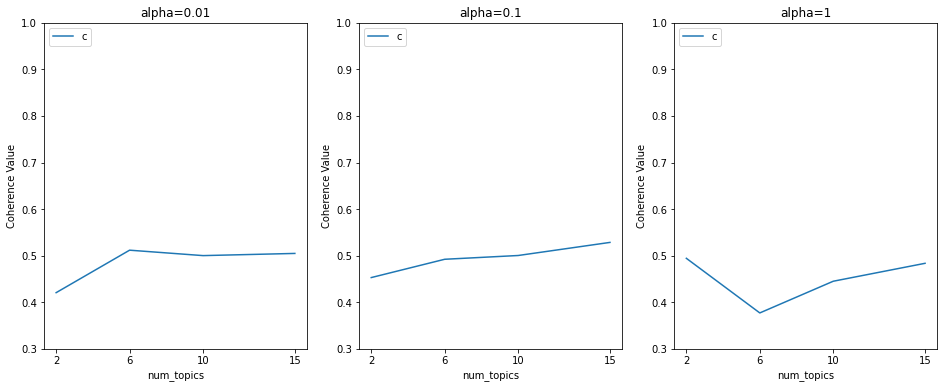

In [34]:
# plot
plot_coherence(coherence_df, alpha_range, num_topics_range)

In [35]:
# Build LDA model with alpha=0.1 and 10 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           per_word_topics=True)

In [36]:
# print keywords 
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.121*"love" + 0.114*"demonetization" + 0.065*"successful" + 0.064*"wave" + '
  '0.054*"index" + 0.042*"effect" + 0.042*"economy" + 0.028*"industrial" + '
  '0.028*"contract" + 0.028*"double"'),
 (1,
  '0.130*"demonetization" + 0.116*"will" + 0.086*"dear" + 0.072*"due" + '
  '0.060*"there" + 0.054*"people" + 0.042*"money" + 0.026*"production" + '
  '0.025*"already" + 0.024*"flag"'),
 (2,
  '0.161*"demonetization" + 0.105*"video" + 0.100*"question" + '
  '0.091*"fisherman" + 0.070*"amp" + 0.044*"slip" + 0.043*"youtubeisdead" + '
  '0.043*"offensive" + 0.022*"can" + 0.020*"lose"'),
 (3,
  '0.130*"cash" + 0.087*"make" + 0.061*"demonetization" + 0.048*"help" + '
  '0.034*"watch" + 0.023*"month" + 0.022*"payment" + 0.021*"post" + '
  '0.019*"mandate" + 0.019*"poverty"'),
 (4,
  '0.100*"poor" + 0.094*"quiet" + 0.094*"englis" + 0.094*"men" + '
  '0.094*"prohibition" + 0.064*"demonetization" + 0.042*"believe" + '
  '0.042*"action" + 0.041*"reflect" + 0.039*"transparent"'),
 (5,
  '0.10

In [37]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5317069003889515


In [38]:
# coherence per topic:
coherence_model_lda.get_coherence_per_topic()

[0.492676724288711,
 0.5242774946515494,
 0.5400728650120606,
 0.4240653591330223,
 0.4829322954548482,
 0.5067022144522104,
 0.5760282995080062,
 0.598808158051938,
 0.5944014846203844,
 0.5771041087167853]

In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.135073  0.004081       1        1  14.821302
6      0.137684  0.012400       2        1  14.806121
8      0.157359  0.005156       3        1  11.913171
5     -0.168225 -0.383450       4        1  11.634659
3     -0.029743  0.068027       5        1  10.928932
2      0.094191  0.032861       6        1   9.209332
0      0.105978  0.014661       7        1   8.716520
4      0.017028 -0.040031       8        1   6.749354
9     -0.294746  0.180230       9        1   5.695431
7     -0.154599  0.106066      10        1   5.525178, topic_info=                Term         Freq         Total Category  logprob  loglift
607             keep  1601.000000   1601.000000  Default  30.0000  30.0000
80              good  1450.000000   1450.000000  Default  29.0000  29.0000
630             will  1580.000000   1580.000000  Default  28.0000  28.0000
719        implement  1570.000000   1570.000000  Default  27.0000  27.0000
15              cash  1314.000000   1314.000000  Default  26.0000  26.0000
...              ...          ...           ...      ...      ...      ...
4457   everification    33.378914     35.139094  Topic10  -5.0277   2.8445
4755       tcofrnake    56.062750     60.867333  Topic10  -4.5091   2.8136
4752          linger    75.841191     84.951803  Topic10  -4.2070   2.7824
43           destroy    21.723884     22.897954  Topic10  -5.4572   2.8432
3     demonetization   178.056242  10616.347782  Topic10  -3.3535  -1.1922

[350 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
176       8  0.997978         action
1370      2  0.999487       actually
458       2  0.998627             ad
4001      6  0.982639     advertiser
151       7  0.986264         affect
...     ...       ...            ...
5367      2  0.002737  youtubeisdead
5367      6  0.990847  youtubeisdead
5367      9  0.002737  youtubeisdead
5367     10  0.002737  youtubeisdead
3503     10  0.974412       youtuber

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 9, 6, 4, 3, 1, 5, 10, 8])

### BBC News Dataset

In [40]:
# reading the BBC news dataset

"""
data_folder = "./bbc"

folders = ["business","entertainment","politics","sport","tech"]

x = []
y = []

for i in folders:
    files = os.listdir(data_folder + "/" + i)
    for text_file in files:
        file_path =  data_folder + "/" + i + "/" + text_file
        with open(file_path, 'rb') as f:
            data = f.read()
#         data = ' '.join(data)
        x.append(data)
        y.append(i)


data = {'news': x, 'type': y}       
df = pd.DataFrame(data)
df.to_csv('bbc_data.csv', index=False)
"""

df = pd.read_csv('bbc_data.csv')

In [41]:
df.head()

,ArticleId,news,type
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   news       1490 non-null   object
 2   type       1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [43]:
# filter business articles
df = df[df['type']=='business']
df.shape

(336, 3)

In [44]:
# convert to list
data = df['news'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# lemmatize
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [45]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [46]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41488106776131495


In [47]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.149504  0.016533       1        1  37.391223
4      0.226819 -0.193458       2        1  24.575412
9      0.155606  0.208045       3        1  12.284549
6      0.054075  0.190247       4        1  12.271262
3      0.162290 -0.110965       5        1   8.726625
8     -0.148719 -0.011239       6        1   2.360700
1     -0.178515 -0.025856       7        1   1.527658
2     -0.160732 -0.030279       8        1   0.653788
5     -0.132143 -0.021938       9        1   0.148646
0     -0.128185 -0.021088      10        1   0.060138, topic_info=            Term        Freq       Total Category  logprob  loglift
428         sale  229.000000  229.000000  Default  30.0000  30.0000
81          year  573.000000  573.000000  Default  29.0000  29.0000
120       growth  262.000000  262.000000  Default  28.0000  28.0000
420       profit  125.000000  125.000000  Default  27.0000  27.0000
165         rise  256.000000  256.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3902     fervour    0.005373    1.482663  Topic10  -8.5400   1.7961
3903      tactic    0.005373    1.482663  Topic10  -8.5400   1.7961
2220         cml    0.005373    1.066022  Topic10  -8.5401   2.1260
2222  consistent    0.005370    1.481337  Topic10  -8.5406   1.7964
2230        host    0.005369    2.460422  Topic10  -8.5409   1.2888

[546 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4560      8  0.667377     absa
1466      1  0.699925   access
1466      6  0.299968   access
921       1  0.312450  account
921       2  0.243017  account
...     ...       ...      ...
4876      6  0.859994  xstrata
81        1  0.271832     year
81        2  0.426915     year
81        4  0.076670     year
81        5  0.224784     year

[791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 10, 7, 4, 9, 2, 3, 6, 1])

## Amazon Cell Phones and Accessories Reviews 


In [48]:
# all electronic products
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Cell_Phones_and_Accessories_5.json.gz')

In [49]:
df.shape

(194439, 9)

In [50]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
5,APX47D16JOP7H,120401325X,RLH,"[1, 2]",These make using the home button easy. My daug...,3.0,Cute,1381536000,"10 12, 2013"
6,A1JVVYYO7G56DS,120401325X,Tyler Evans,"[0, 0]",Came just as described.. It doesn't come unstu...,5.0,best thing ever..,1377129600,"08 22, 2013"
7,A6FGO4TBZ3QFZ,3998899561,Abdullah Albyati,"[1, 2]",it worked for the first week then it only char...,1.0,not a good Idea,1384992000,"11 21, 2013"
8,A2JWEDW5FSVB0F,3998899561,Adam,"[2, 3]","Good case, solid build. Protects phone all aro...",5.0,Solid Case,1380067200,"09 25, 2013"
9,A8AJS1DW7L3JJ,3998899561,Agata Majchrzak,"[1, 1]",This is a fantastic case. Very stylish and pro...,5.0,Perfect Case,1396483200,"04 3, 2014"


In [51]:
# convert to list
data = df['reviewText'].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# lemmatize
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create corpus
texts = data_lemmatized

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [52]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [53]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4123674662202076


In [54]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.221228 -0.075161       1        1  22.952502
8     -0.157635  0.111799       2        1  16.219848
4     -0.026797  0.183224       3        1  12.489768
1     -0.293082  0.000917       4        1   9.071655
5     -0.157088 -0.219052       5        1   9.003519
0      0.067413 -0.252326       6        1   8.180240
3      0.048210 -0.151659       7        1   8.085989
6      0.213604  0.105482       8        1   5.463843
7     -0.014757  0.198332       9        1   5.085721
2      0.098904  0.098443      10        1   3.446915, topic_info=            Term           Freq          Total Category  logprob  loglift
76          case  150062.000000  150062.000000  Default  30.0000  30.0000
68        charge  119413.000000  119413.000000  Default  29.0000  29.0000
14         phone  184876.000000  184876.000000  Default  28.0000  28.0000
28           use  107864.000000  107864.000000  Default  27.0000  27.0000
3           good   66380.000000   66380.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
791        heart    2006.214462    2006.825153  Topic10  -4.8275   3.3674
735   additional    1948.024772    1948.635346  Topic10  -4.8569   3.3674
185      husband    1914.071704    1914.682283  Topic10  -4.8745   3.3674
1746      signal    1817.376784    1817.987313  Topic10  -4.9264   3.3674
1424      memory    1769.358138    1769.968631  Topic10  -4.9531   3.3673

[366 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
468      10  0.999880    ability
238       2  0.999934       able
73        4  0.999797     access
1012      9  0.999726  accessory
103       1  0.999991        add
...     ...       ...        ...
1028      9  0.999956   wireless
22        3  0.999990       work
518       8  0.999746      worry
599       8  0.999651      wrong
29        2  0.999917       year

[369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 5, 2, 6, 1, 4, 7, 8, 3])